In [ ]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from joblib import dump, load
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
dataset=pd.read_csv('twitter_training.csv',header=None)
dataset.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [ ]:
files=['twitter_training.csv','twitter_validation.csv']
#train set
dataset_train=pd.read_csv(files[0],header=None)
dataset_train.drop(0,inplace=True,axis=1)
dataset_train.drop(1,inplace=True,axis=1)
titel=['sentiment','tweet']
dataset_train.columns=titel
dataset
dataset_train['sentiment']=dataset_train['sentiment'].replace({'Positive':1, 'Neutral': 0, 'Negative': 2})
dataset_train.head(100)
dataset_train=dataset_train[dataset_train['sentiment']!= 'Irrelevant']
#test set
dataset_test=pd.read_csv(files[1],header=None)
dataset_test.drop(0,inplace=True,axis=1)
dataset_test.drop(1,inplace=True,axis=1)
titel=['sentiment','tweet']
dataset_test.columns=titel
dataset
dataset_test['sentiment']=dataset_test['sentiment'].replace({'Positive':1, 'Neutral': 0, 'Negative': 2})
dataset_test.head(100)
dataset_test=dataset_test[dataset_test['sentiment']!= 'Irrelevant']

In [ ]:
#clean Data
from nltk.stem import PorterStemmer
import pandas as pd
import re
import nltk
from nltk.corpus import words
from nltk.corpus import stopwords
nltk.download('words')
english_words = set(words.words())
stemmer=PorterStemmer()
# Define the patterns you want to remove
pattern = '[^a-z|A-Z|\s]|a{2,}|\s{2,}|â|Â|\n'
big_data=[dataset_train,dataset_test]
for data in big_data :
  for i in range(len(data)):
      try :
          #match unneeded words from text and substitute them with ""
          matched=re.findall(pattern,data['clean_text'][i])
          cleaned_text = re.sub(pattern, "", data['clean_text'][i])
          #nlp=spacy.blank("en")
          #doc=nlp(cleaned_text)  #split cleaned data into words and check for stop/english words
          filtered_words = []
          cleaned_list=cleaned_text.split(' ')
          for token in cleaned_list:
              stemmer.stem(token) # derive stem of words
              filtered_words.append(token)
          data['clean_text'][i] = ' '.join(filtered_words)
          if data['clean_text'][i]=='' or data['clean_text'][i]==' '  :
              #print("true")
              data=data.drop(data[i]) #get rid of empty lines
      except:
          pass

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
nan_indices = dataset_train['sentiment'].index[dataset_train['sentiment'].isna()]
print(nan_indices)
dataset_train.drop(nan_indices, inplace=True)
nan_indices = dataset_train['tweet'].index[dataset_train['tweet'].isna()]
print(nan_indices)
dataset_train.drop(nan_indices, inplace=True)
nan_indices = dataset_test['sentiment'].index[dataset_test['sentiment'].isna()]
print(nan_indices)
dataset_test.drop(nan_indices, inplace=True)
nan_indices = dataset_test['tweet'].index[dataset_test['tweet'].isna()]
print(nan_indices)
dataset_test.drop(nan_indices, inplace=True)
data = pd.concat([dataset_train, dataset_test], ignore_index=True)
print(data)

Int64Index([], dtype='int64')
Int64Index([   61,   553,   589,   745,  1105,  1106,  2413,  2929,  2983,
             2997,
            ...
            73761, 73762, 73763, 73855, 73971, 73972, 73973, 74421, 74422,
            74423],
           dtype='int64', length=571)
Int64Index([], dtype='int64')
Int64Index([], dtype='int64')
      sentiment                                              tweet
0             1  im getting on borderlands and i will murder yo...
1             1  I am coming to the borders and I will kill you...
2             1  im getting on borderlands and i will kill you ...
3             1  im coming on borderlands and i will murder you...
4             1  im getting on borderlands 2 and i will murder ...
...         ...                                                ...
61944         2  Please explain how this is possible! How can t...
61945         1  Good on Sony. As much as I want to see the new...
61946         1  Today sucked so it’s time to drink wine n play.

In [ ]:
from nltk.tokenize import word_tokenize

from torch.nn.utils.rnn import pad_sequence
import torch
nltk.download('punkt')
# Tokenize the text data into words for each tweet
tokenized_text = [word_tokenize(text) for text in data['tweet']]

# Create a vocabulary set to store unique words from the tokenized text
vocab = set(word for tokens in tokenized_text for word in tokens)
vocab_size = len(vocab)
print("Vocabulary Size:", vocab_size)

# Create a dictionary to store the occurrence count of each word
word_occurrence = {}

# Count the occurrences of each word in the tokenized text
for tokens in tokenized_text:
    for word in tokens:
        if word in word_occurrence:
            word_occurrence[word] += 1
            if word_occurrence[word] > 10000:
                word_occurrence[word] = 10000
        else:
            word_occurrence[word] = 1

# Replace the words in tokenized text with their occurrence counts
tokenized_text_with_counts = [[word_occurrence[word] for word in tokens] for tokens in tokenized_text]


# Convert the tokenized text with word counts into torch tensors
tensor_sequences = [torch.tensor(sequence) for sequence in tokenized_text_with_counts]

# Pad the tensor sequences to create equal-length sequences for batch processing
padded_sequences = pad_sequence(tensor_sequences, batch_first=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Vocabulary Size: 43675


In [ ]:
print(padded_sequences.shape)
X=padded_sequences
y=data['sentiment'].values
print(X.shape)

torch.Size([61949, 198])
torch.Size([61949, 198])


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize


# Train Word2Vec model on the tokenized_text data
model_w2v = Word2Vec(sentences=tokenized_text, vector_size=200, window=5, min_count=1, workers=4)

# Create a dictionary to store word embeddings (word vectors) for each word in the vocabulary
word_embeddings = {word: model_w2v.wv[word] for word in model_w2v.wv.key_to_index}

# Create a list of word embeddings for all words in the vocabulary
word_vector_list = [word_embeddings[word] for word in model_w2v.wv.key_to_index]

# Convert the list of word embeddings into a numpy array
word_embeddings_np = np.stack(word_vector_list)


# Print the shape of the word embeddings numpy array
print("Shape of word embeddings array:", word_embeddings_np.shape)

Shape of word embeddings array: (43675, 200)


In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.9 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel
# Load the pre-trained BERT tokenizer
all_input_ids = []
all_attention_masks = []

data_sentences = data['tweet'].tolist()


# Load the pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Loop through all the text sequences in data_sentences
for text in data_sentences:
    # Tokenize and encode each text sequence
    encoded_text = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        padding='max_length',
        max_length=64,
        return_tensors='pt',
        return_attention_mask=True,
        truncation=True
    )
    # Get the input IDs and attention mask tensors for the current text sequence
    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']

    # Add the input IDs and attention masks to the lists
    all_input_ids.append(input_ids)
    all_attention_masks.append(attention_mask)

# Stack the input IDs and attention masks into tensors
input_ids_tensor = torch.cat(all_input_ids, dim=0)
attention_mask_tensor = torch.cat(all_attention_masks, dim=0)

# Print the shape of the tensors to verify
print("Input IDs Shape:", input_ids_tensor.shape)
print("Attention Mask Shape:", attention_mask_tensor.shape)

Input IDs Shape: torch.Size([61949, 64])
Attention Mask Shape: torch.Size([61949, 64])


In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification,DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split



labels = torch.tensor(y[:20000].astype(int), dtype=torch.long)

# Create a TensorDataset
dataset = TensorDataset(input_ids_tensor[:20000], attention_mask_tensor[:20000], labels)

# Set the seed for reproducibility
torch.manual_seed(42)

# Split the dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Set batch size for DataLoader
batch_size = 100

# Create DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the BERT model for sequence classification
num_labels = len(set(y))
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_ids, attention_mask, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accurcay: {accuracy:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5, Loss: 0.7523
Epoch 2/5, Loss: 0.4195
Epoch 3/5, Loss: 0.2221
Epoch 4/5, Loss: 0.1168
Epoch 5/5, Loss: 0.0739
Test Accurcay: 0.9293


In [ ]:

from sklearn.metrics import confusion_matrix, classification_report

model.eval()
y_test_list = []
y_pred_list = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, predicted = torch.max(logits, 1)

        y_test_list.extend(labels.cpu().numpy())
        y_pred_list.extend(predicted.cpu().numpy())
cm = confusion_matrix(y_test_list, y_pred_list)
print("Confusion Matrix:")
print(cm)


report = classification_report(y_test_list, y_pred_list)
print("Classification Report:")
print(report)
with open('classification_report_Bert1.txt', 'w') as file:
    file.write(report)

Confusion Matrix:
[[1164   95   25]
 [  30 1367   37]
 [  27   69 1186]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1284
           1       0.89      0.95      0.92      1434
           2       0.95      0.93      0.94      1282

    accuracy                           0.93      4000
   macro avg       0.93      0.93      0.93      4000
weighted avg       0.93      0.93      0.93      4000



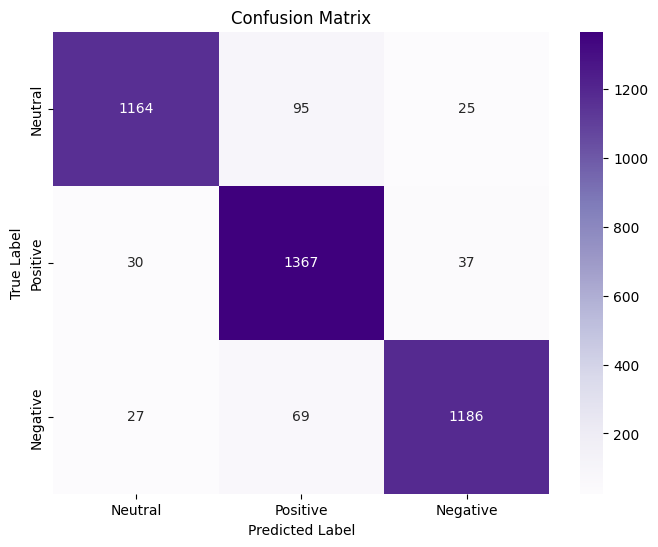

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = [[1164,95,25],
 [30,1367,37],
 [27,69,1186]]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Purples', fmt='d', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('confusion matrix BERT1.pdf')
plt.show()